In this notebook, we determine what fraction of events of a particular reaction have muon that enters the detector,
making the simplifying assumption that there is a uniform distribution of the particles' kinematics in the available phase space.
The reaction is $e p \rightarrow e'D_0\Lambda_c^+$ followed by $\Lambda_c^+\rightarrow\Lambda^0\bar\nu_\mu\mu^+$.  In principle,
the code used in this simplified event generator could be used for other reactions as well.  

The generation of three-particle events follows Phys. Rev. D 86, 114023 (2012) https://arxiv.org/abs/1210.7939 .  

In [3]:
import ROOT, numpy as np, random, pandas as pd
rand = random.Random()
import matplotlib as mpl, matplotlib.pylab as plt, matplotlib.patches as patches

plt.rcParams["figure.figsize"] = [7.00, 5.00]
#presets for plot style
rc = plt.rc
rc('text', usetex=False)
rc('font', family='serif')
rc('font', size=16)
rc('xtick', labelsize=16)
rc('ytick', labelsize=16)
rc('axes', labelsize=16)
rc('legend', fontsize=16)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

pdg = ROOT.TDatabasePDG()

In [4]:
class oneToTwoGenerator():
    def __init__(self, m0, m1, m2):
        self.m1 = m1
        self.m2 = m2
        self.m0 = m0
        self.p = np.sqrt(m1**4+m2**4+m0**4-2*m1**2*m0**2-2*m1**2*m2**2-2*m0**2*m2**2)/(2*m0)
        self.E1 = np.hypot(m1, self.p) 
        self.E2 = np.hypot(m2, self.p)
    
    def next(self, P0):
        phi=rand.uniform(-np.pi, np.pi)
        cosTheta=rand.uniform(-1,1)
        sinTheta=np.sqrt(1-cosTheta**2)
        
        p = self.p
        P1 = ROOT.TLorentzVector(p*np.cos(phi)*sinTheta, p*np.sin(phi)*sinTheta, p*cosTheta, self.E1)
        P2 = ROOT.TLorentzVector(-p*np.cos(phi)*sinTheta, -p*np.sin(phi)*sinTheta, -p*cosTheta, self.E2)
        beta = P0.BoostVector()
        P1.Boost(beta)
        P2.Boost(beta)
        #print((P0-P1-P2).M())
        #print((P0-P1-P2).E())
        return P1,P2

 Use the formulas found here to get the 3-particle phase space:  Phys. Rev. D 86, 114023 (2012) https://arxiv.org/abs/1210.7939 

In [5]:
class oneToThreeGenerator():
    def __init__(self, m0, m1, m2, m3):
        self.m0 = m0
        self.x1 = (m1/self.m0)**2
        self.x2 = (m2/self.m0)**2
        self.x3 = (m3/self.m0)**2
        
        self.s13_min = (np.sqrt(self.x1)+np.sqrt(self.x3))**2
        self.s13_max =(1-np.sqrt(self.x2))**2
        print("s13 range:", self.s13_min, self.s13_max)
        self.s13s =np.linspace(self.s13_min,self.s13_max, 1024+2)[1:-1]
        self.pdf = np.sqrt(((1+self.x2-self.s13s)**2-4*self.x2)*((self.x1+self.x3-self.s13s)**2-4*self.x1*self.x3))/self.s13s
        self.pdf /= np.sum(self.pdf)
        self.cdf = [self.pdf[0]]
        for i in range(1,len(self.pdf)):
            self.cdf.append(self.cdf[-1]+self.pdf[i])
        
    def next(self, P0,search="binary"):
        
        #these are for particle 2:
        phi=rand.uniform(-np.pi, np.pi)
        cosTheta=rand.uniform(-1,1)
        sinTheta=np.sqrt(1-cosTheta**2)

        #pdf of s13 is sqrt(((1+x2-s12)^2-4x^2)((x1+x3-s13)^2-4*x1*x3))/s13

        u = rand.uniform(0, 1)
        psum = 0
        s13= (self.s13_min+self.s13_max)/2
        if search == "linear":
            found=False
            for i in range(len(self.cdf)):
                if(self.cdf[i]>u):
                    s13=self.s13s[i]
                    found = True
                    break
            if not found:
                raise Exception("s13 not found in table")
        #perform binary search
        if search == "binary":
            i=512
            di=256
            while di >=1:
                if (u> self.cdf[i]):
                    i+=di
                else :
                    i -=di
                di=di//2
            s13=self.s13s[i]


        p2 = np.sqrt(s13**2 + self.x2**2+1 - 2*s13 - 2*s13*self.x2 - 2*self.x2)/2
        P2 = ROOT.TLorentzVector(p2*np.cos(phi)*sinTheta, p2*np.sin(phi)*sinTheta, p2*cosTheta, np.sqrt(self.x2+p2**2))


        p = np.sqrt(s13**2 + self.x3**2 + self.x1**2 - 2*self.x1*self.x3 - 2*s13*self.x3 - 2*s13*self.x1)/(2*np.sqrt(s13))

        #these are for particles 1, 3
        phi=rand.uniform(-np.pi, np.pi)
        cosTheta=rand.uniform(-1,1)
        sinTheta=np.sqrt(1-cosTheta**2)

        P1 = ROOT.TLorentzVector(p*np.cos(phi)*sinTheta, p*np.sin(phi)*sinTheta, p*cosTheta, np.sqrt(self.x1+p**2))
        P3 = ROOT.TLorentzVector(-p*np.cos(phi)*sinTheta, -p*np.sin(phi)*sinTheta, -p*cosTheta, np.sqrt(self.x3+p**2))


        boost = P2.Vect()#*(-1/np.sqrt(p2**2+s13))
        boost*=(-1/np.sqrt(p2**2+s13))

        P1.Boost(boost)
        P3.Boost(boost)

        beta = P0.BoostVector()
        P1.Boost(beta)
        P2.Boost(beta)
        P3.Boost(beta)
        #print((P0-P1-P2).M())
        #print((P0-P1-P2).E())
        return P1*self.m0,P2*self.m0,P3*self.m0

In [6]:
#similar to the oneToThreeGenerator, except with a delta function on Q^2 = (P2-P0)^2, where P2 is the scattered electron
class PhotoproductionGenerator():
    def __init__(self, m0, m1, m2, m3):
        self.m0 = m0
        self.x1 = (m1/self.m0)**2
        self.x2 = (m2/self.m0)**2
        self.x3 = (m3/self.m0)**2
        
        self.s13_min = (np.sqrt(self.x1)+np.sqrt(self.x3))**2
        self.s13_max =(1-np.sqrt(self.x2))**2
        print("s13 range:", self.s13_min, self.s13_max)
        self.s13s =np.linspace(self.s13_min,self.s13_max, 1024+2)[1:-1]
        
        #pdf of s13 is sqrt(((1+x2-s12)^2-4x^2)((x1+x3-s13)^2-4*x1*x3))/s13 for non-photoproduction
        self.pdf = np.sqrt(((1+self.x2-self.s13s)**2-4*self.x2)*((self.x1+self.x3-self.s13s)**2-4*self.x1*self.x3))/self.s13s
        #multiply by an additional factor of 1/p2_cm because of the delta function on Q2.
        p2 = (1-self.s13s)/2
        self.pdf/=p2
        
        self.pdf /= np.sum(self.pdf)
        self.cdf = [self.pdf[0]]
        for i in range(1,len(self.pdf)):
            self.cdf.append(self.cdf[-1]+self.pdf[i])
        
    def next(self, P0,search="binary"):
        
        #these are for particle 2:
        phi=0
        cosTheta=1 #electron is going in the forward direction, since Q^2 goes to zero
        sinTheta=0

        

        u = rand.uniform(0, 1)
        psum = 0
        s13= (self.s13_min+self.s13_max)/2
        if search == "linear":
            found=False
            for i in range(len(self.cdf)):
                if(self.cdf[i]>u):
                    s13=self.s13s[i]
                    found = True
                    break
            if not found:
                raise Exception("s13 not found in table")
        #perform binary search
        if search == "binary":
            i=512
            di=256
            while di >=1:
                if (u> self.cdf[i]):
                    i+=di
                else :
                    i -=di
                di=di//2
            s13=self.s13s[i]


        p2 = np.sqrt(s13**2 + self.x2**2+1 - 2*s13 - 2*s13*self.x2 - 2*self.x2)/2
        P2 = ROOT.TLorentzVector(p2*np.cos(phi)*sinTheta, p2*np.sin(phi)*sinTheta, p2*cosTheta, np.sqrt(self.x2+p2**2))


        p = np.sqrt(s13**2 + self.x3**2 + self.x1**2 - 2*self.x1*self.x3 - 2*s13*self.x3 - 2*s13*self.x1)/(2*np.sqrt(s13))

        #these are for particles 1, 3
        phi=rand.uniform(-np.pi, np.pi)
        cosTheta=rand.uniform(-1,1)
        sinTheta=np.sqrt(1-cosTheta**2)

        P1 = ROOT.TLorentzVector(p*np.cos(phi)*sinTheta, p*np.sin(phi)*sinTheta, p*cosTheta, np.sqrt(self.x1+p**2))
        P3 = ROOT.TLorentzVector(-p*np.cos(phi)*sinTheta, -p*np.sin(phi)*sinTheta, -p*cosTheta, np.sqrt(self.x3+p**2))


        boost = P2.Vect()#*(-1/np.sqrt(p2**2+s13))
        boost*=(-1/np.sqrt(p2**2+s13))

        P1.Boost(boost)
        P3.Boost(boost)

        beta = P0.BoostVector()
        P1.Boost(beta)
        P2.Boost(beta)
        P3.Boost(beta)
        #print((P0-P1-P2).M())
        #print((P0-P1-P2).E())
        return P1*self.m0,P2*self.m0,P3*self.m0

### User Inputs and constants

In [41]:
Ebeam=10 #GeV

mp=.9383
mn=.9396
mD0=1.86484
mLambdaC=2.2849
mLambda=1.115683
me=0.000511
mMu=0.1057
mpi_charged = 0.1396
mpi0 = 0.1350
mK0=0.497611
mKshort=mK0
mK_charged=0.493677
mrho0=0.77549
mrho_charged=0.77526
mSigma0=1.192642
mSigmaP=1.18937
mSigmaN=mSigmaP

stot = (Ebeam+mp)**2-Ebeam**2
x1 = mD0**2/stot
x2 = 0.000511**2/stot
x3 = mLambdaC**2/stot

P0=ROOT.TLorentzVector(0, 0, Ebeam,Ebeam+mp)
#DIS Event Generator
#ep_to_d0_e_lambdac= oneToThreeGenerator(P0.M(), mD0, me, mLambdaC)
ep_to_d0_e_lambdac= PhotoproductionGenerator(P0.M(), mD0, me, mLambdaC)

#Decay generators; decays for the lambda_c taken from 
#https://pdglive.lbl.gov/Particle.action?init=0&node=S033&home=BXXX040
DecayChannels = []
BranchingRatios = []


#lambda_c -> muon + X modes
DecayChannels.append("$\\lambda \\mu^+, \\lambda \\rightarrow p \\pi^0$")
DecayChannels.append("$\\lambda \\mu^+, \\lambda \\rightarrow n \\pi^+$")
lambdac_to_lambdamu = oneToThreeGenerator(mLambdaC, mLambda, 0, mMu) #BR= 3.5e-2 +- 0.5e-2
f_lambdac_to_lambdamu = 0.035
f_lambdac_to_lambdamu_unc = 0.005
BranchingRatios.append(f_lambdac_to_lambdamu*f_lambda_to_ppi)
BranchingRatios.append(f_lambdac_to_lambdamu*f_lambda_to_npi)

#lambda_c -> n + X modes
lambdac_to_nKspi = oneToThreeGenerator(mLambdaC, mn, mpi_charged, mKshort)
f_lambdac_to_nKspi = 0.0182
f_lambdac_to_nKspi_unc = 0.0025
#secondary K_s decay
Kshort_to_picharged = oneToTwoGenerator(mKshort,mpi_charged,mpi_charged)
Kshort_to_picharged = 0.692
Kshort_to_picharged_unc = 0.0005
Kshort_to_pi0 = oneToTwoGenerator(mKshort,mpi0,mpi0)
Kshort_to_pi0 = 0.307
Kshort_to_pi0_unc = 0.0005

#lambda_c -> p + X modes

#lambda -> n/p + X intermediate resonance
f_lambdac_lambda=.382 #inclusive lambda_c -> lambda + X
lambdac_to_lambdapi = oneToTwoGenerator(mLambdaC, mLambda, mpi_charged) #BR= 1.3e-2 +- 0.07e-2
f_lambdac_to_lambdapi = 0.013
f_lambdac_to_lambdapi_unc = 0.0007
lambdac_to_lambdapipi0 = oneToThreeGenerator(mLambdaC, mLambda, mpi_charged, mpi0) #BR= 7.1e-2 +- 0.4e-2 (includes intermediate rho state, <6%)
f_lambdac_to_lambdapipi0 = 0.011
f_lambdac_to_lambdapipi0_unc = 0.004
lambdac_to_lambdarho = oneToTwoGenerator(mLambdaC, mLambda, mrho_charged) #BR= 7.1e-2 +- 0.4e-2 (includes intermediate rho state, <6%)
f_lambdac_to_lambdarho = 0.06
f_lambdac_to_lambdarho_unc = 0.03
lambdac_to_lambdaKK0 = oneToThreeGenerator(mLambdaC, mLambda, mK0, mK_charged) #BR= 0.57e-2 +- 0.11e-2
f_lambdac_to_lambdaKK0 = 0.0057
f_lambdac_to_lambdaKK0_unc = 0.0011
lambdac_to_lambdarhopi = oneToThreeGenerator(mLambdaC, mLambda, mrho0, mpi_charged) #BR= 0.57e-2 +- 0.11e-2
f_lambdac_to_lambdarhopi = 0.015
f_lambdac_to_lambdarhopi_unc = 0.006
#lambdac_to_lambda3pi = needs 1-4 generator #BR= 3.64e-2 +- 0.29e-2 (includes intermediate states) BR<1.1e-2 (nonresonant)
#secondary lambda decay
lambda_to_npi = oneToTwoGenerator(mLambda, mn, mpi0)
f_lambda_to_npi=.36
lambda_to_ppi = oneToTwoGenerator(mLambda, mp, mpi_charged)
f_lambda_to_ppi=.64
#secondary rho_charged decay
rho_to_pipi0 = oneToTwoGenerator(mrho_charged, mpi0, mpi_charged)
f_rho_to_pipi0=.995
rho_to_pi0pi0 = oneToTwoGenerator(mrho0, mpi_charged, mpi_charged)
f_rho_to_pipi=.99

#SigmaP -> n/p + X intermediate resonance
lambdac_to_SigmaPpi0 = oneToTwoGenerator(mLambdaC, mSigmaP, mpi0) #BR= 0.57e-2 +- 0.11e-2
f_lambdac_to_SigmaPpi0 = 0.0125
f_lambdac_to_SigmaPpi0_unc = 0.001
#secondary SimgaP decay
SigmaP_to_ppi0 = oneToTwoGenerator(mSigmaP, mp, mpi0) #BR= 0.57e-2 +- 0.11e-2
f_SigmaP_to_ppi0 = 0.5157
f_SigmaP_to_ppi0_unc = 0.003
SigmaP_to_npi = oneToTwoGenerator(mSigmaP, mn, mpi_charged) #BR= 0.57e-2 +- 0.11e-2
f_SigmaP_to_npi = 0.4831
f_SigmaP_to_npi_unc = 0.003
SigmaP_to_pgamma = oneToTwoGenerator(mSigmaP, mp, 0) #BR= 0.57e-2 +- 0.11e-2
f_SigmaP_to_npi = 0.00123
f_SigmaP_to_npi_unc = 0.0005

#SigmaN -> n/p + X intermediate resonance
#lambdac_to_ = oneToTwoGenerator(mLambdaC, mSigmaN, mn, mpi_charged)
#f_lambdac_to_ = 
#f_lambdac_to_ = 
#secondary SimgaN decay
SigmaN_to_npi = oneToTwoGenerator(mSigmaN, mn, mpi0) #BR= 0.57e-2 +- 0.11e-2
f_SigmaN_to_npi = 0.99848
f_SigmaN_to_npi_unc = 0.001
SigmaN_to_npi = oneToThreeGenerator(mSigmaN, mn, me, 0) #BR= 0.57e-2 +- 0.11e-2
f_SigmaN_to_npi = 0.001017
f_SigmaN_to_npi_unc = 0.00034

#sigma0 -> n/p + X intermediate resonance
lambdac_to_Sigma0pi = oneToTwoGenerator(mLambdaC, mSigma0, mpi_charged) #BR= 0.57e-2 +- 0.11e-2
f_lambdac_to_Sigma0pi = 0.0129
f_lambdac_to_Sigma0pi_unc = 0.0007
#secondary simga0 decay

s13 range: 0.8765135611827901 0.9997694398246769
s13 range: 0.2857388855110227 1.0
s13 range: 0.39564590009832684 0.8815392833362078
s13 range: 0.2996126170503792 0.8815392833362078
s13 range: 0.4961031795779794 0.6118643776935416
s13 range: 0.3018206147200554 0.4363952858537377
s13 range: 0.6240969446046626 0.9991409061483323


In [119]:
DecaySelector = rand.uniform(0,sum(BranchingRatios))
cumulant = 0
for BRindex in range(len(BranchingRatios)):
    cumulant += BranchingRatios[BRindex]
    if DecaySelector < cumulant:
        ChannelIndex = BRindex
        break
print(DecayChannels[ChannelIndex])

$\lambda \mu^+, \lambda \rightarrow \p \pi^0$


In [48]:
sum(BranchingRatios)

0.035

In [12]:
#lambdac -> lambda + pi
d1 = {a+"_"+b:[] for a in "DecayChannel Int_Names Int_E Int_px ".split() for b in "E px py pz p theta phi".split()}

#nucleon type that the lambda decays into (2212 or 2112 for p or n)
d1["Ntype"] =[]
for i in range(100000):
    d = {}
    d["D0"],d["e"],d["lambdac"] = ep_to_d0_e_lambdac.next(P0)
    
    
    d["lambda"],d["pi"]= lambdac_to_lambdapi.next(d["lambdac"])
    
    if(rand.uniform(0,1)<.64):
        Ntype = 2212
        d["N_lambda"], d["pi_lambda"] = lambda_to_ppi.next(d['lambda'])
    else :
        Ntype= 2112
        d["N_lambda"], d["pi_lambda"] = lambda_to_npi.next(d['lambda'])
    d1["Ntype"].append(Ntype)
    
    for key in d.keys():
        d1[key + "_E"].append(d[key].E())
        d1[key + "_px"].append(d[key].Px())
        d1[key + "_py"].append(d[key].Py())
        d1[key + "_pz"].append(d[key].Pz())
        d1[key + "_p"].append(d[key].P())
        d1[key + "_theta"].append(d[key].Theta())
        d1[key + "_phi"].append(d[key].Phi())
df_pi = pd.DataFrame(d1)

In [39]:
d1 = {a:[] for a in "decay_channel int_names final_names".split()}
d1.update({a+"_"+b:[] for a in "Int Final".split() for b in "E px py pz p theta phi".split()})
#can we search through a list/1D array in the IntParticleNames slot to find all decays with intermediate lambda?
#Do we need to append Ntype if we can search the final_names for 2112/GeantID/"n"

nEvents = 100000

for i in range(nEvents):
    #select which decay channel to use
    DecaySelector = rand.uniform(0,sum(BranchingRatios))
    cumulant = 0
    for BRindex in range(len(BranchingRatios)):
        cumulant += BranchingRatios[BRindex]
        if DecaySelector < cumulant:
            DecayIndex = BRindex
            break
    #hard code each channel by hand?
    if DecayIndex = 0:
        
    
    d = {}
    #try to have a list of generators -- requires knowing the particles which will come out of each PrimaryDecay
    d["D0"],d["e"],d["lambdac"] = PrimaryDecay[DecayIndex].next(P0)
    
    
    d["lambda"],d["pi"]= lambdac_to_lambdapi.next(d["lambdac"])
    
    if(rand.uniform(0,1)<.64):
        Ntype = 2212
        d["N_lambda"], d["pi_lambda"] = lambda_to_ppi.next(d['lambda'])
    else :
        Ntype= 2112
        d["N_lambda"], d["pi_lambda"] = lambda_to_npi.next(d['lambda'])
    d1["Ntype"].append(Ntype)
    
    for key in d.keys():
        d1[key + "_E"].append(d[key].E())
        d1[key + "_px"].append(d[key].Px())
        d1[key + "_py"].append(d[key].Py())
        d1[key + "_pz"].append(d[key].Pz())
        d1[key + "_p"].append(d[key].P())
        d1[key + "_theta"].append(d[key].Theta())
        d1[key + "_phi"].append(d[key].Phi())
df_pi = pd.DataFrame(d1)

In [40]:
d1

{'DecayChannel': [],
 'IntNames': [],
 'FinalNames': [],
 'Int_E': [],
 'Int_px': [],
 'Int_py': [],
 'Int_pz': [],
 'Int_p': [],
 'Int_theta': [],
 'Int_phi': [],
 'Final_E': [],
 'Final_px': [],
 'Final_py': [],
 'Final_pz': [],
 'Final_p': [],
 'Final_theta': [],
 'Final_phi': []}

In [15]:
#lambdac -> lambda + mu + neutrino decay
d1 = {a+"_"+b:[] for a in "D0 e lambdac lambda numu mu N pi".split() for b in "E px py pz p theta phi".split()}
#nucleon type that the lambda decays into (2212 or 2112 for p or n)
d1["Ntype"] =[]
for i in range(100000):
    d = {}
    d["D0"],d["e"],d["lambdac"] = ep_to_d0_e_lambdac.next(P0)
    
    
    d["lambda"],d["numu"],d["mu"] = lambdac_to_lambdamu.next(d["lambdac"])
    
    if(rand.uniform(0,1)<.64):
        Ntype = 2212
        d["N"], d["pi"] = lambda_to_ppi.next(d['lambda'])
    else :
        Ntype= 2112
        d["N"], d["pi"] = lambda_to_npi.next(d['lambda'])
    d1["Ntype"].append(Ntype)
    
    for key in d.keys():
        d1[key + "_E"].append(d[key].E())
        d1[key + "_px"].append(d[key].Px())
        d1[key + "_py"].append(d[key].Py())
        d1[key + "_pz"].append(d[key].Pz())
        d1[key + "_p"].append(d[key].P())
        d1[key + "_theta"].append(d[key].Theta())
        d1[key + "_phi"].append(d[key].Phi())
df = pd.DataFrame(d1)

In [16]:
def check_decay(df, mother, daughters):
    masses={}
    masses["D0"]=mD0
    masses["lambdac"]=mLambdaC
    masses["lambda"]=mLambda
    masses["mu"]=mMu
    masses["numu"]=0
    #first check conservation of momentum
    for comp in "E px py pz".split():
        #build a string to be evaluated by the df
        str1=mother+"_"+comp
        for d in daughters:
            str1+=" - "+d+"_"+comp
        print(comp,np.mean(df.eval(f"({str1})**2")))
    #next check that the four momenta of the mother and daughter particles have the correct masses.
    for part in [mother]+daughters:
        str2=f"({part}_E**2-{part}_px**2-{part}_py**2-{part}_pz**2)-{masses[part]}**2"
        print(part, np.mean(df.eval(str2)**2))
check_decay(df, "lambdac", ["lambda", "mu", "numu"])

E 2.3107275877700523e-29
px 8.426562244370477e-32
py 8.433436582617245e-32
pz 2.0181576915589517e-29
lambdac 6.861278650784415e-29
lambda 1.1802582369547494e-29
mu 1.0247093269470972e-30
numu 8.5543665248025e-31


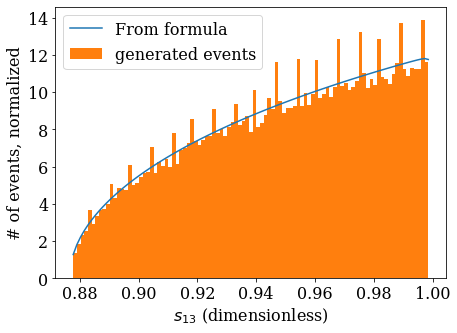

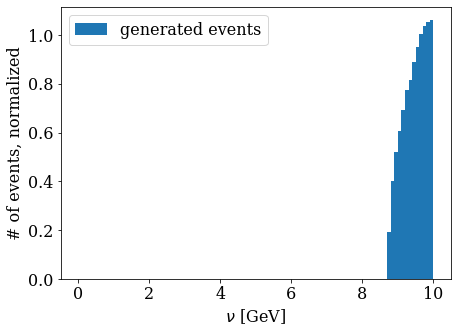

In [17]:
#check the distribution of the s13 variable, and the photon energy for the photoproduction

#show the pdf for the s13 variable
Ebeam=10
mD0=1.86484
mLambdaC=2.2849
mp = 0.9383
stot = (Ebeam+mp)**2-Ebeam**2
x1 = mD0**2/stot
x2 = 0.000511**2/stot
x3 = mLambdaC**2/stot

s13_min = (np.sqrt(x1)+np.sqrt(x3))**2
s13_max =(1-np.sqrt(x2))**2
s13 =np.linspace(s13_min,s13_max, 100)[1:-1]
binwidth=s13[1]-s13[0]
pdf = np.sqrt(((1+x2-s13)**2-4*x2)*((x1+x3-s13)**2-4*x1*x3))/s13
#apply photoproduction correction
pdf /=(1-s13)/2
pdf /=sum(pdf)*binwidth
plt.plot(s13, pdf, label="From formula")

plt.hist(df.eval(f"((D0_E+lambdac_E)**2-(D0_px+lambdac_px)**2-(D0_py+lambdac_py)**2-(D0_pz+lambdac_pz)**2)/{P0.M()**2}"), bins=s13,density = True, label="generated events")
plt.legend()
plt.xlabel("$s_{13}$ (dimensionless)")
plt.ylabel("# of events, normalized")
plt.show()

plt.hist(df.eval(f"{Ebeam}-e_E"), bins=np.linspace(0, Ebeam,101),density = True, label="generated events")
plt.legend()
plt.xlabel("$\\nu$ [GeV]")
plt.ylabel("# of events, normalized")
plt.show()

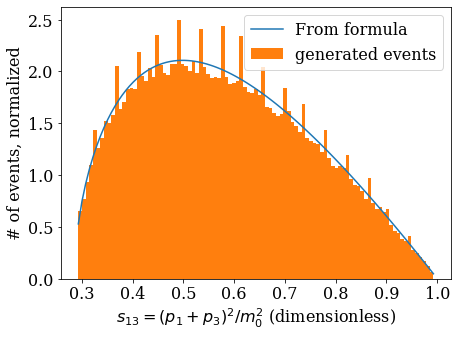

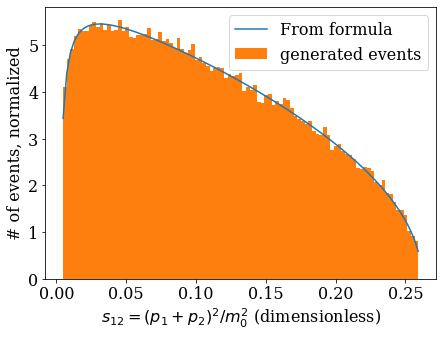

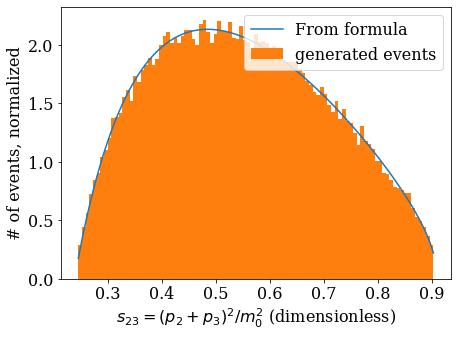

In [18]:
#check the distributions of the s13, s23, and s12 variables in the lambdac decay


stot = mLambdaC**2
x1 = mMu**2/stot
x2 = 1e-7/stot
x3 = mLambda**2/stot

part1="mu"
part2="numu"
part3="lambda"

s13_min = (np.sqrt(x1)+np.sqrt(x3))**2
s13_max =(1-np.sqrt(x2))**2
s13 =np.linspace(s13_min,s13_max, 100)[1:-1]
binwidth=s13[1]-s13[0]
pdf = np.sqrt(((1+x2-s13)**2-4*x2)*((x1+x3-s13)**2-4*x1*x3))/s13

pdf /=sum(pdf)*binwidth
plt.plot(s13, pdf, label="From formula")

plt.hist(df.eval(f"(({part1}_E+{part3}_E)**2-({part1}_px+{part3}_px)**2-({part1}_py+{part3}_py)**2-({part1}_pz+{part3}_pz)**2)/{stot}"), bins=s13,density = True, label="generated events")
plt.legend()
plt.xlabel("$s_{13}=(p_1+p_3)^2/m^2_0$ (dimensionless)")
plt.ylabel("# of events, normalized")
plt.show()

s12_min = (np.sqrt(x1)+np.sqrt(x2))**2
s12_max =(1-np.sqrt(x3))**2
s12 =np.linspace(s12_min,s12_max, 100)[1:-1]
binwidth=s12[1]-s12[0]
pdf = np.sqrt(((1+x3-s12)**2-4*x3)*((x1+x2-s12)**2-4*x1*x2))/s12

pdf /=sum(pdf)*binwidth
plt.plot(s12, pdf, label="From formula")
part1="mu"
part3="lambda"
plt.hist(df.eval(f"(({part1}_E+{part2}_E)**2-({part1}_px+{part2}_px)**2-({part1}_py+{part2}_py)**2-({part1}_pz+{part2}_pz)**2)/{stot}"), bins=s12,density = True, label="generated events")
plt.legend()
plt.xlabel("$s_{12}=(p_1+p_2)^2/m^2_0$ (dimensionless)")
plt.ylabel("# of events, normalized")
plt.show()

s23_min = (np.sqrt(x3)+np.sqrt(x2))**2
s23_max =(1-np.sqrt(x1))**2
s23 =np.linspace(s23_min,s23_max, 100)[1:-1]
binwidth=s23[1]-s23[0]
pdf = np.sqrt(((1+x1-s23)**2-4*x1)*((x2+x3-s23)**2-4*x2*x3))/s23

pdf /=sum(pdf)*binwidth
plt.plot(s23, pdf, label="From formula")
part1="mu"
part3="lambda"
plt.hist(df.eval(f"(({part2}_E+{part3}_E)**2-({part2}_px+{part3}_px)**2-({part2}_py+{part3}_py)**2-({part2}_pz+{part3}_pz)**2)/{stot}"), bins=s23,density = True, label="generated events")
plt.legend()
plt.xlabel("$s_{23}=(p_2+p_3)^2/m^2_0$ (dimensionless)")
plt.ylabel("# of events, normalized")
plt.show()

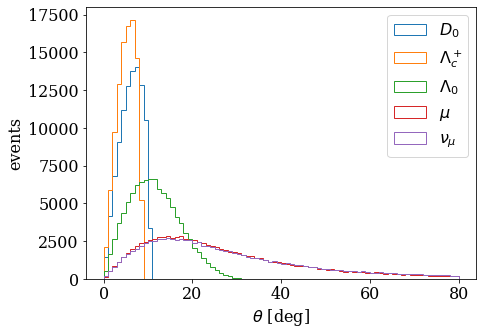

In [19]:
plt.hist(df.D0_theta*180/np.pi,bins=np.linspace(0,80,81), label="$D_0$", histtype='step')
plt.hist(df.lambdac_theta*180/np.pi,bins=np.linspace(0,80,81), label="$\\Lambda^+_c$", histtype='step')
plt.hist(df.lambda_theta*180/np.pi,bins=np.linspace(0,80,81), label="$\Lambda_0$", histtype='step')
plt.hist(df.mu_theta*180/np.pi,bins=np.linspace(0,80,81), label="$\\mu$", histtype='step')
plt.hist(df.numu_theta*180/np.pi,bins=np.linspace(0,80,81), label="$\\nu_\\mu$", histtype='step')
plt.legend()
plt.xlabel("$\\theta$ [deg]")
plt.ylabel("events")
plt.show()

In [20]:
#what fraction of the events have a muon that enters the acceptance of the fcal?
#plot the theta distribution of the accepted events and all events.
z_front = 1300
detector_length=300
detector_ymin = -220
detector_ymax = -8
uxmax = (detector_length/2)/z_front
uymin = detector_ymin/z_front
uymax = detector_ymax/z_front

def acceptance_condition(particle_name):
    return f"abs({particle_name}_px/{particle_name}_pz)<{uxmax} and {particle_name}_py/{particle_name}_pz>{uymin} and {particle_name}_py/{particle_name}_pz<{uymax}"

0.05682 +- 0.0007320620711387799


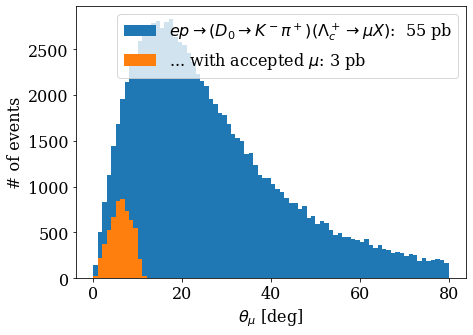

In [26]:
#muon acceptance
tot_nb = 40

f_D0_Kminus_piplus=.03946


accepted = df.query(acceptance_condition("mu"))
num = len(accepted)
denom = len(df)
print(num/denom, "+-", np.sqrt(num*(denom-num)/denom**3))



#label =f"all events with muon:  {tot_nb*f_lamdba_c_mu:.2f} nb"
label = f"$ep\\rightarrow (D_0\\rightarrow K^-\\pi^+) (\\Lambda_c^+\\rightarrow \\mu X)$:  {tot_nb*f_lambdac_to_lambdamu*f_D0_Kminus_piplus*1000:.0f} pb"
plt.hist(df.mu_theta*180/np.pi,bins=np.linspace(0,80,81), label=label)

#label = f"events with accepted muon\n{tot_nb*f_lambda_c_mu*num/denom:.2f} nb\n({num/denom*100:.1f}$\pm${np.sqrt(num*(denom-num)/denom**3)*100:.1f}% of total)"
#label = f"events with accepted muon:\n{tot_nb*f_lambda_c_mu*num/denom:.2f} nb"
label = f"... with accepted $\\mu$: {tot_nb*f_lambdac_to_lambdamu*f_D0_Kminus_piplus*num/denom*1000:.0f} pb"
plt.hist(accepted.mu_theta*180/np.pi,bins=np.linspace(0, 80, 81), label=label)
plt.legend()
plt.xlabel("$\\theta_\mu$ [deg]")
plt.ylabel("# of events")
plt.show()

0.16816331083719113 +- 0.001975111551324876


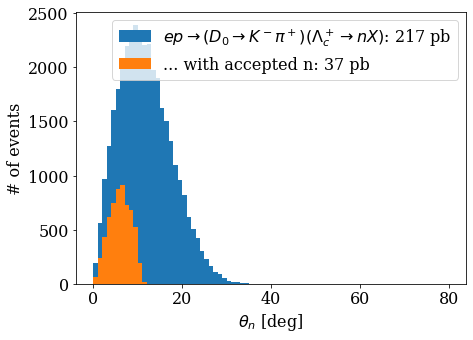

In [27]:
#neutron acceptance:
accepted = df.query(acceptance_condition("N") +" and Ntype==2112")
num = len(accepted)
denom = len(df.query("Ntype==2112"))
print(num/denom, "+-", np.sqrt(num*(denom-num)/denom**3))





label=f"$ep\\rightarrow (D_0\\rightarrow K^-\\pi^+) (\\Lambda_c^+\\rightarrow n X)$: {tot_nb*f_D0_Kminus_piplus*f_lambdac_lambda*f_lambda_to_npi*1000:.0f} pb"
plt.hist(df.query("Ntype==2112").N_theta*180/np.pi,bins=np.linspace(0,80,81), label =label)
#plt.hist(accepted.N_theta*180/np.pi,bins=np.linspace(0, 80, 81), label=f"events with accepted neutron\n({num/denom*100:.1f}$\pm${np.sqrt(num*(denom-num)/denom**3)*100:.1f}% of total)")
plt.hist(accepted.N_theta*180/np.pi,bins=np.linspace(0, 80, 81), label=f"... with accepted n: {tot_nb*f_D0_Kminus_piplus*f_lambdac_lambda*f_lambda_to_npi*num/denom*1000:.0f} pb")


plt.legend()
plt.xlabel("$\\theta_n$ [deg]")
plt.ylabel("# of events")
plt.show()

0.1646658975398335 +- 0.0014644032701182038


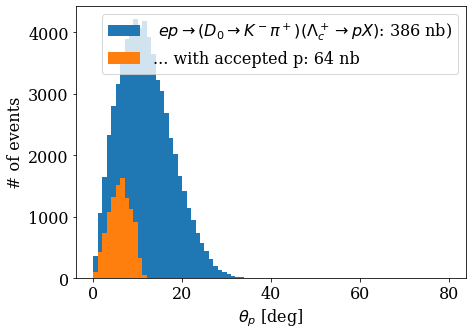

In [28]:
#proton acceptance:
accepted = df.query(acceptance_condition("N") +" and Ntype==2212")
num = len(accepted)
denom = len(df.query("Ntype==2212"))
print(num/denom, "+-", np.sqrt(num*(denom-num)/denom**3))

label =f" $ep\\rightarrow (D_0\\rightarrow K^-\\pi^+) (\\Lambda_c^+\\rightarrow p X)$: {tot_nb*f_D0_Kminus_piplus*f_lambdac_lambda*f_lambda_to_ppi*1000:.0f} nb)"
plt.hist(df.query("Ntype==2212").N_theta*180/np.pi,bins=np.linspace(0,80,81), label =label)
#plt.hist(accepted.N_theta*180/np.pi,bins=np.linspace(0, 80, 81), label=f"events with accepted proton\n({num/denom*100:.1f}$\pm${np.sqrt(num*(denom-num)/denom**3)*100:.1f}% of total)")
label=f"... with accepted p: {num/denom*tot_nb*f_D0_Kminus_piplus*f_lambdac_lambda*f_lambda_to_ppi*1000:.0f} nb"
plt.hist(accepted.N_theta*180/np.pi,bins=np.linspace(0, 80, 81), label =label)
plt.legend()
plt.xlabel("$\\theta_p$ [deg]")
plt.ylabel("# of events")
plt.show()

0.05682 +- 0.0007320620711387799
0.00219 +- 0.0001478243518504309
0.00364 +- 0.00019044028985485187


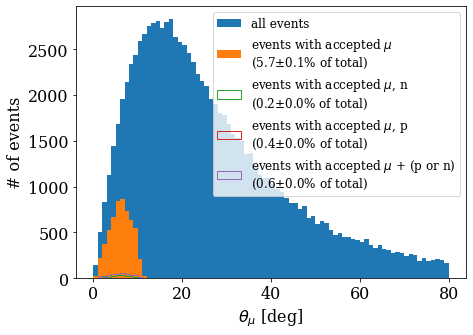

In [25]:
#plot events in which both the muon and the nucleon are within acceptance.
accepted_mu = df.query(acceptance_condition("mu"))
num = len(accepted_mu)
denom = len(df)
print(num/denom, "+-", np.sqrt(num*(denom-num)/denom**3))

plt.hist(df.mu_theta*180/np.pi,bins=np.linspace(0,80,81), label ="all events")
plt.hist(accepted_mu.mu_theta*180/np.pi,bins=np.linspace(0, 80, 81), label=f"events with accepted $\mu$\n({num/denom*100:.1f}$\pm${np.sqrt(num*(denom-num)/denom**3)*100:.1f}% of total)")

accepted_mu_n = df.query(acceptance_condition("mu")+ " and "+ acceptance_condition("N") + " and Ntype==2112")
num = len(accepted_mu_n)
print(num/denom, "+-", np.sqrt(num*(denom-num)/denom**3))
plt.hist(accepted_mu_n.mu_theta*180/np.pi,bins=np.linspace(0, 80, 81), 
         label=f"events with accepted $\mu$, n\n({num/denom*100:.1f}$\pm${np.sqrt(num*(denom-num)/denom**3)*100:.1f}% of total)",
          histtype='step')

accepted_mu_p = df.query(acceptance_condition("mu")+ " and "+ acceptance_condition("N") + " and Ntype==2212")
num = len(accepted_mu_p)
print(num/denom, "+-", np.sqrt(num*(denom-num)/denom**3))
plt.hist(accepted_mu_p.mu_theta*180/np.pi,bins=np.linspace(0, 80, 81), 
         label=f"events with accepted $\mu$, p\n({num/denom*100:.1f}$\pm${np.sqrt(num*(denom-num)/denom**3)*100:.1f}% of total)",
          histtype='step')

accepted_mu_p_or_n = df.query(acceptance_condition("mu")+ " and "+ acceptance_condition("N"))
num = len(accepted_mu_p_or_n)

plt.hist(accepted_mu_p.mu_theta*180/np.pi,bins=np.linspace(0, 80, 81), 
         label=f"events with accepted $\mu$ + (p or n)\n({num/denom*100:.1f}$\pm${np.sqrt(num*(denom-num)/denom**3)*100:.1f}% of total)",
          histtype='step')

plt.legend(fontsize=12)
plt.xlabel("$\\theta_\mu$ [deg]")
plt.ylabel("# of events")
plt.show()

In [40]:
nb_tot=40

f_lamdba_c_mu = 0.035
f_lamdba_c_e = 0.036

print("sigma (mu+)=", nb_tot*f_lamdba_c_mu)
print("sigma (mu+, accepted)=", nb_tot*f_lamdba_c_mu*.116)
print("sigma (mu+, n, accepted)=", nb_tot*f_lamdba_c_mu*.007)
print("sigma (mu+, p, accepted)=", nb_tot*f_lamdba_c_mu*.012)
print("sigma (mu+, p or n, accepted)=", nb_tot*f_lamdba_c_mu*.019)

sigma (mu+)= 1.4000000000000001
sigma (mu+, accepted)= 0.16240000000000002
sigma (mu+, n, accepted)= 0.009800000000000001
sigma (mu+, p, accepted)= 0.016800000000000002
sigma (mu+, p or n, accepted)= 0.026600000000000002


In [42]:
def toLund(df, filename):
    with open(filename, "w") as f:
        for i in range(len(df)):
#             1 Number of particles
#             2 Mass number of the target (UD)
#             3 Atomic number oif the target (UD)
#             4 Target polarization (UD)
#             5 Beam Polarization
#             6 Beam type, electron=11, photon=22” (UD)
#             7 Beam energy (GeV) (UD)
#             8 Interacted nucleon ID (2212 or 2112) (UD)
#             9 Process ID (UD)
#             10 Event weight (UD)

            #for now just include the electron and the muon
            print(2, 1, 1,0, 0, 11,Ebeam,2212, 0, 1, file=f)
            for j,(particle_name, pid) in enumerate([("e", 11), ("mu", -13)]):
                particle = pdg.GetParticle(pid)
                print(j+1, particle.Lifetime()/1e9, 1, pid, 0,0, 
                      df[particle_name + "_"+"px"][i], 
                      df[particle_name + "_"+"py"][i],
                      df[particle_name + "_"+"pz"][i],
                      df[particle_name + "_"+"E"][i],
                      particle.Mass(), 0,0,0, file=f)

In [43]:
toLund(df, "100kemufromlambdac.dat")